In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


In [6]:
results_dir = Path("../results")
selected_models = [
    "phi4:14b",
    "qwen3:14b",
    "granite3.3:2b",
    "mistral:7b",
]

def load_results(pattern: str) -> pd.DataFrame:
    files = sorted(results_dir.glob(pattern))
    if not files:
        raise FileNotFoundError(f"No result files found for pattern: {pattern}")

    df = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)
    df["avg_latency"] = pd.to_numeric(df["avg_latency"], errors="coerce")
    df["id_acc"] = pd.to_numeric(df["id_acc"], errors="coerce")
    df["ood_acc"] = pd.to_numeric(df["ood_acc"], errors="coerce")

    if "gqr_score" in df.columns:
        df["gqr_score"] = pd.to_numeric(df["gqr_score"], errors="coerce")
    else:
        df["gqr_score"] = 2 / (1 / df["id_acc"] + 1 / df["ood_acc"])

    return df

def plot_results(df: pd.DataFrame, title: str) -> None:
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.scatter(
        df["avg_latency"],
        df["gqr_score"],
        color="#9e9e9e",
        edgecolor="#3a3a3a",
        linewidth=0.6,
        s=80,
        zorder=2,
    )

    for _, row in df.iterrows():
        offset = (6, -8) if row["model"] == "llama3.3:70b" else (6, 6)
        ax.annotate(
            row["model"],
            (row["avg_latency"], row["gqr_score"]),
            textcoords="offset points",
            xytext=offset,
            fontsize=9,
            fontweight="normal",
        )

    selected = df[df["model"].isin(selected_models)].copy()
    selected = selected.sort_values("avg_latency")
    if not selected.empty:
        ax.plot(
            selected["avg_latency"],
            selected["gqr_score"],
            color="red",
            marker="o",
            linestyle="--",
            linewidth=1.5,
            markersize=8,
            zorder=3,
        )

    ax.set_xscale("log")
    ax.set_xlabel("Time Per Sample (log scale)")
    ax.set_ylabel("GQR-Score")
    if title:
        ax.set_title(title)
    ax.grid(True, alpha=0.15)

    ax.annotate(
        "",
        xy=(0.35, 0.97),
        xytext=(0.7, 0.97),
        xycoords="axes fraction",
        arrowprops=dict(arrowstyle="-|>", color="#7a7a7a", lw=1.2),
    )
    ax.text(
        0.9,
        0.975,
        "FASTER",
        transform=ax.transAxes,
        ha="left",
        va="center",
        color="#7a7a7a",
        fontsize=11,
    )
    ax.annotate(
        "",
        xy=(0.03, 0.7),
        xytext=(0.03, 0.4),
        xycoords="axes fraction",
        arrowprops=dict(arrowstyle="-|>", color="#7a7a7a", lw=1.2),
    )
    ax.text(
        0.02,
        0.55,
        "BETTER",
        transform=ax.transAxes,
        rotation=90,
        ha="center",
        va="left",
        color="#7a7a7a",
        fontsize=11,
    )

    fig.tight_layout()


## Baseline (Current)


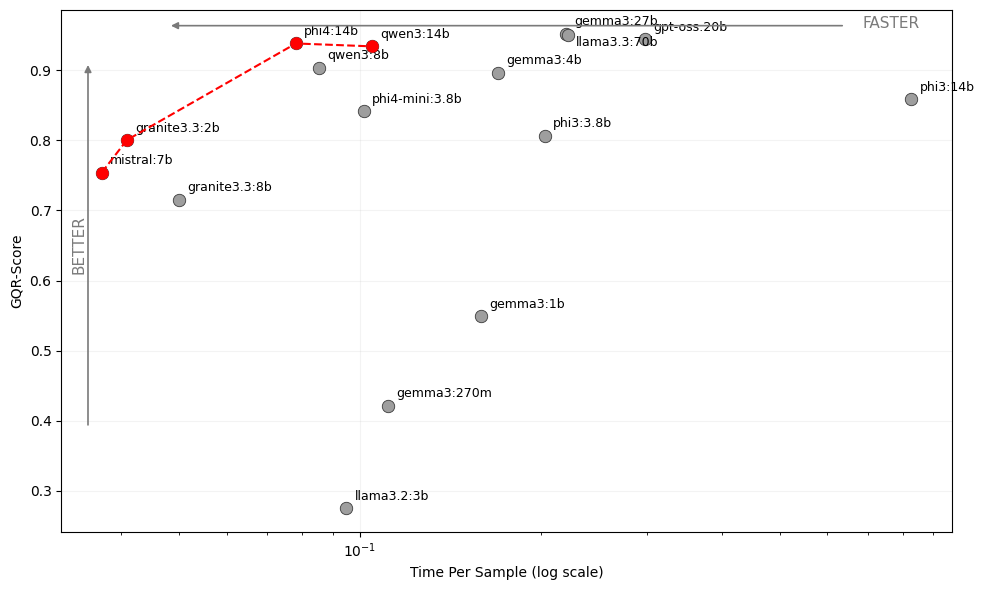

In [3]:
baseline_df = load_results("benchmark_results_*.csv")
plot_results(baseline_df, "")


## Selected model comparison


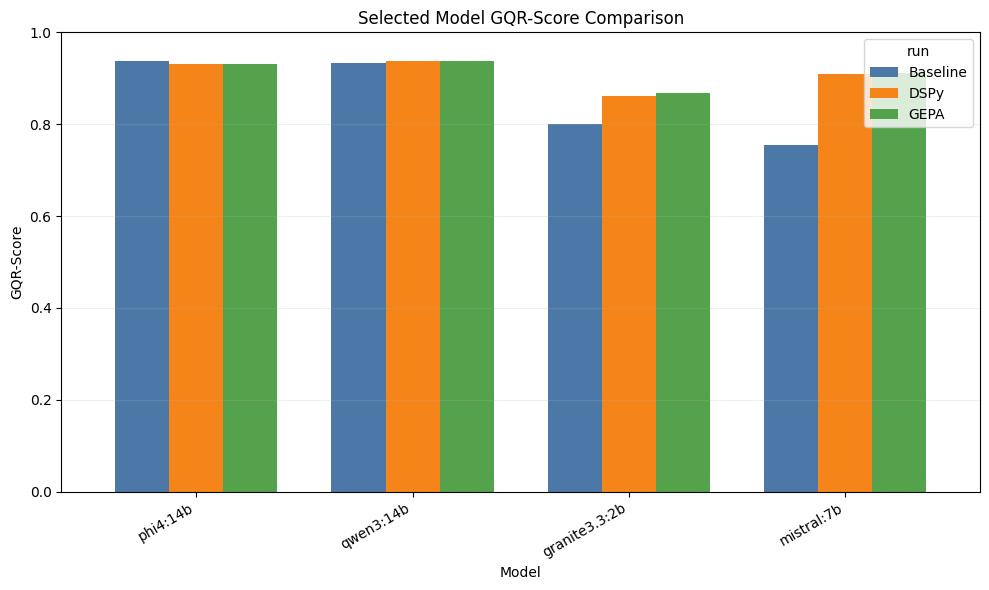

In [4]:
def try_load_results(pattern: str) -> pd.DataFrame | None:
    try:
        return load_results(pattern)
    except FileNotFoundError:
        return None

runs = {
    "Baseline": try_load_results("benchmark_results_*.csv"),
    "DSPy": try_load_results("dspy_results_*.csv"),
    "GEPA": try_load_results("gepa_results_*.csv"),
}

rows = []
for label, df in runs.items():
    if df is None:
        continue
    subset = df[df["model"].isin(selected_models)].copy()
    subset["run"] = label
    rows.append(subset)

if not rows:
    raise ValueError("No result files found for selected model comparison.")

plot_df = pd.concat(rows, ignore_index=True)
plot_df = plot_df.dropna(subset=["gqr_score"])
if plot_df.empty:
    raise ValueError("No selected model rows found for comparison.")

pivot = plot_df.pivot_table(
    index="model",
    columns="run",
    values="gqr_score",
    aggfunc="mean",
)
pivot = pivot.reindex(selected_models)

palette = ["#4c78a8", "#f58518", "#54a24b"]
labels = list(pivot.columns)
fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_facecolor("#f7f3ed")
ax.set_facecolor("#fbf7f0")

x = np.arange(len(pivot.index))
bar_width = 0.22

for idx, label in enumerate(labels):
    values = pivot[label].values
    offset = (idx - (len(labels) - 1) / 2) * bar_width
    bars = ax.bar(
        x + offset,
        values,
        width=bar_width,
        color=palette[idx % len(palette)],
        edgecolor="#3a3a3a",
        linewidth=0.6,
        label=label,
        zorder=3,
    )
    for bar in bars:
        height = bar.get_height()
        if np.isnan(height):
            continue
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + 0.015,
            f"{height:.2f}",
            ha="center",
            va="bottom",
            fontsize=8,
            color="#2e2e2e",
            zorder=4,
        )

for row_idx, model in enumerate(pivot.index):
    row = pivot.loc[model]
    if row.isna().all():
        continue
    best_run = row.idxmax()
    best_val = row.max()
    best_idx = labels.index(best_run)
    best_offset = (best_idx - (len(labels) - 1) / 2) * bar_width
    ax.scatter(
        row_idx + best_offset,
        best_val + 0.03,
        marker="*",
        s=90,
        color="#1f1f1f",
        zorder=5,
    )

ax.set_xticks(x)
ax.set_xticklabels(pivot.index)
ax.set_xlabel("Model")
ax.set_ylabel("GQR-Score")
ax.set_title("Selected Model GQR-Score Comparison")
ax.set_ylim(0, 1.05)
ax.grid(axis="y", alpha=0.2, zorder=0)
ax.legend(title="Run", frameon=False)

plt.xticks(rotation=30, ha="right")
plt.tight_layout()
